# HERA Memo: Creating Auto-Correlations with a Generative Adverserial Neural Network 

### Joseph C. Shy, 2021 CHAMP Scholar, 08/13/2021
#### Questions? Contact me: jshy@calpoly.edu or joeyshy883@gmail.com

**NOTE:** If running this notebook locally, please download all files from `/users/jshy/mylustre/machine_learning/2459122-H4C_Machine-Learning_Practice` if `lustre` is accessible. Make note that some directory names will need to be changed before some functions are ran again. 

If access to `lustre` is not possible, the notebook will not be useable, as HERA auto-correlations are required .

organize github and include here

define autocorrelation??? need to show an example somewhere before model discussions

**MAY CHANGE LATENT SPACE AND BATCH SIZE, BEWARE BEFORE FINALIZATIoN**

## 1. Introduction & Machine Learning Basics

### 1.1. Machine Learning applied to HERA
As the HERA radio antenna array continues to be developed, modified, and built upon, the challenge of identifying working antennas from their broken counterparts becomes a major priority before analysis can be performed with the data retrieved. Currently, the standard for the HERA collaboration is to visually assess auto-correlations that are returned from every observing antenna on a specific night of observation. Each assessment is performed manually by an operator and repeated by a handful of other operators for thoroughness and redundancy. 

Below are examples of arbitrary `PASS` and `NO PASS` auto-correlations. Note the large spikes in the `PASS` measurement. These are caused by RFI channel interference. This presentation will assist in understand the patterns operators must looks for in good auto-correlations.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

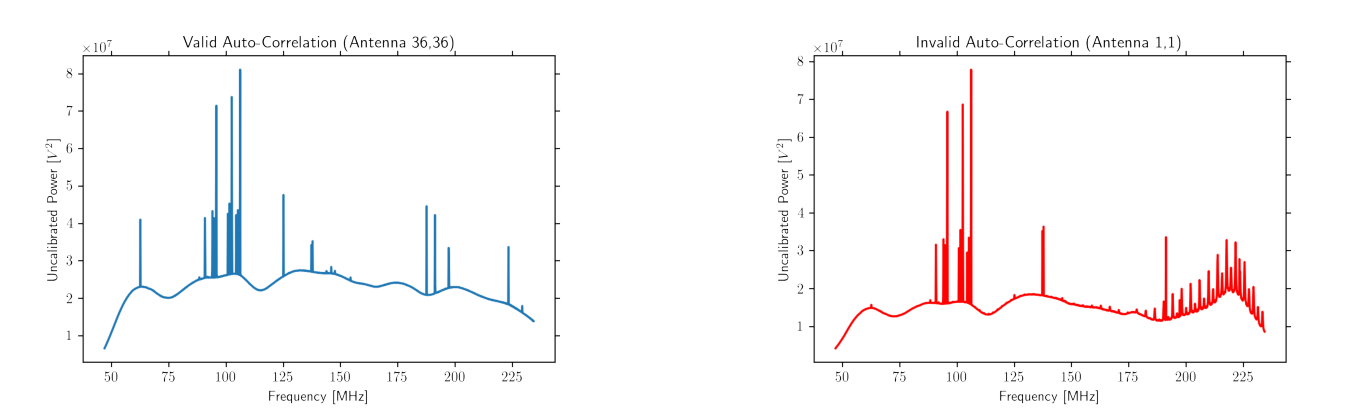

In [2]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(24,12))
img1 = mpimg.imread('valid_example-auto.png')
ax1.imshow(img1)
ax1.axis('off')
img2 = mpimg.imread('invalid_example-auto.png')
ax2.imshow(img2)
ax2.axis('off')
plt.show()

The end condition of the invalid auto-correlation is far from similar to that of the good auto-correlation.

This process can prove inconvenient, as it requires a large amount of focused time to gain confidence in the flag given to a certain antenna (the flag states its potential issue or if it is cleared for use). Additionally, it is close to impossible to visually check every auto-correlation that is computed every night (typically > 100,000). Therefore, this leads to the situation where a good auto-correlation from an antenna flagged as broken may be discarded as it was not screened. It is in best interest to preserve as much data from each antenna as possible. 

Machine learning, and more specifically, a generative adversarial neural network (or GAN), has potential to automate and improve the current system for flagging antennas. The current working networks that will be focused on in the sections below are designed to be able to:
1. Screen every auto-correlation produced.
2. Flag an auto-correlation as `PASS` or `NO PASS` 

These two goals will be achievable through a system called a generative adversarial neural network. It is a machine-learning idea that trains a system to know exactly what a good-quality, `PASS` auto-correlation looks like. But rather than training the system to know exactly what a previously-identified, `NO PASS` auto-correlation looks like, it is trained on `FAKE` auto-correlations that deviate from `REAL` auto-correlations only slightly. The `FAKE` auto-correlations will be elaborated upon in the following sections. However, this choice of training on `FAKE` measurements that look very similar to a `REAL` auto-correlation provides the system to be able to only identify `NO PASS` auto-correlations ambiguously. This means it will be able to detect new errors in the antennas that have not been seen before. But this ambiguity also has a fall back, as it will not be able to define the exact problem with the auto-correlation but rather simply the presence of one.

This system will have the potential to greatly reduce the amount of time required for operators to assess the auto-correlations, instead with their roles being only to classify the issues in the `NO PASS` auto-correlations. Additionally, the ability to screen every auto-correlation should increase the influx of useable data for analysis. 

However, even more automation of this system could be achievable in the future. One potential route for future work would be to create another machine learning architecture to feed the `NO PASS` measurements into. This system's goal would be to identify the exact problem with these auto-correlatios. Please refer to **fUTRUE WORK** for more details.

### 1.2. Basics of a GAN
A [generative adversarial neural network](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/) is a clever combination of two deep learning architectures. These deep learning architectures are ["computing system(s) made up of a number of simple, highly interconnected processing elements, which process information by their dynamic state response to external inputs" ](https://towardsdatascience.com/a-gentle-introduction-to-neural-networks-series-part-1-2b90b87795bc). The basic learning scheme for a neural network involves inputting a data set with specific flags (or classifiers) associated to each singular piece of data within the set (ie. image or plot) and allowing the processing elements within the neural network to update/learn in order to improve in its ability to classify certain sets of data. Each time a model updates its processing elements (or weights) is called an epoch. The magnitude in which the neural network updates its processing elements (or neurons) is based on the result of the loss at each training epoch. However, this is the most basic application of neural networks, but they can be manipulated to do much more, which will be elaborated upon next.

The two learning architectures described within this memo are refered to as the detector model and the generator model. The general idea is to make the two models compete against one another. The generator's goal is to incrementally improve in its ability to create fake auto-correlations that look real. The detector's goal is to become better at discriminating between `REAL` and `FAKE` measurements. 

The detector model operates similarly to the basic classification neural network described above; however, the classifications that the detector trains upon are `REAL` and `FAKE`. It receives an input training set of auto-correlations that are deemed good for analysis. Accompanying these input auto-correlations are classfication flags (which are simply integers of 1 arranged in a list the size of the auto-correlation training set) that are used to communicate to the detector model that the incoming input values are `REAL` auto-correlations. Additionally, the detector receives `FAKE` auto-correlations generated from the generator model. At each epoch, the detector will train and improve in its ability to discriminate between `REAL` and `FAKE` auto-correlations. 

However, the generator model trains as well, learning how to better create `FAKE` auto-correlations that increasingly resemble good auto-correlations. The method in which this occurs is by combining the generator and discriminator model into a larger overarching GAN learning architecture. It is important to note that within the GAN model, the discrimator cannot be trained/updated. The input is a [latent space](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d), which is a set of random numbers vectors returned from the [standard normal distribution](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_probability/bs704_probability9.html). This generator receives this latent space and performs a set of hidden mathematical operations on it, which are derived from the model's architecture and weights. The output of this generator is a `FAKE` auto-correlation, which is subsequently fed into the detector model with a `REAL` classification. This is where the generator training occurs, as the detector will most likely return large losses, as it is being fed information contradicting its previous training outside the GAN architecture. The detector model will output a loss value which the generator uses to update its model weights in order to be able to create `FAKE` auto-correlations that will better trick the detector. Again, the contradictory information fed into the detector will not infuence its own training and ability to discriminate between `REAL` and `FAKE` data, as within the GAN model, the detector is restricted from updating its model weights. 

### 1.3 Objectives
With the previous aspects of the project addressed, the summation of the goals of the project are driven towards showing a proof of concept of both: building a quality, practical GAN for HERA auto-correlations and succcessfully presenting its possible application to the HERA pipeline. 

The objectives are as follows:
1. Create a GAN that returns consistent results (or has a high success rate for correct identification for REAL and FAKE values).
2. Create a GAN architecture that trains with auto-correlations efficiently (in 10,000 epochs or less). This number is an upper-limit, as preliminary GANs for this project were almost able to train in under 10,000 epochs; therefore the objective is to improve upon previous, preliminary training efficiencies.
3. Create a GAN that can screen auto-correlations from broken antennas and successfully identify them as NO PASS (or FAKE). 

## 2. Data Set Selection 
When training a GAN, the selection of the training set is vital for streamlining time to train and to prevent training failure. With HERA's correlators constantly seeing improvement and modifications, what is seen as a good auto-correlation that validates an antenna's use can vary dependent on the data set. The trend of the measurement over the frequency range and/or the magnitude of the power measured at each frequency may differ between different sets. Additionally, each antenna produces auto-correlations of varying polarizations, which differeniate from one another as well. 

As this study is to serve as a validation of GAN architecture for detecting and producing fake auto-correlations, it is important not to expand the training set to be too large and/or too complex. Showing the GAN auto-correlation sets that are all considered valid but differ signficantly from one another, will most likely result in much longer GAN training times or GAN training failure, as neural networks rely heavily on being able to distinguish overarching features and relationships between multiple auto-correlations in a training set. 

Therefore, the down-selection to using only  manually-validated `"ee"` polarized `H4C` auto-correlations on the observation night of `2459122` is made. This training set is used as a case study in order to learn/create a working GAN architecture that can delineate between real and fake auto-correlations and produce realistic auto-correlations from random input vectors, known as the `latent space`. 

### 2.1. Creating the Data Sets
In order to train the GAN on what valid auto-correlations look like, there can only be valid data in the training set. Fortunately, the data mentioned above was chosen as it was previously validated by members of the HERA collaboration and had more successful/valid antenna measurements than other data sets. There were bad antennas within this set (which are listed under the list "ex_ants" [here](https://docs.google.com/spreadsheets/d/1xFo2PLVUhXHe-yqHHl0WrRe5pXZF2zC8Z1fLqPZbPZ8/edit#gid=418790055)) that were removed from the rest of the data. 

Please reference the '*.txt' files within this current directory/Github. They store the filenames, filepaths, and antenna keys (both good and bad) for accessing auto-correlations on the observation night of `2459122`.

The auto-correlation data is retrieved from `Lustre` through the filepath `/lustre/aoc/projects/hera/H4C/2459122`. All files within this directory are used, with the good `"ee"` polarized antennas being separated, organized, and saved locally (the code is omitted as it is not the focus of this study). 

The auto-correlation data is concatenated and separated into '.npy' files for quick local access. However, these files are too large for Github storage (but can be found in `/users/jshy/mylustre/machine_learning/2459122-H4C_Machine-Learning_Practice` in the `herapost-master` node of `ssh.aoc.nrao.edu`. 

Please use this `download-training-data_joseph-shy_HERA-GAN` notebook, within this directory/Github, if interested how to access `Lustre` and create these numpy files for personal local use **(HERA NRAO accessed is required)**.

The data is loaded in below.

In [3]:
import numpy as np

**NOTE:** 11.25% of the valid auto-correlations are split into a separate set that will not be used for model training. This will be used a the validation set. 3.75% of the valid auto-correlations are to be used as a test set to evaluate the model after training. The resulting 75% of the valid auto-corelations will be used to train the models. These small fractions are used for validation and testing as the number of present auto-correlations is extremely large, so a small fraction still yields a signficant test/validation set (see data below).

In [4]:
auto_data_train = np.load('2459122_good_auto-corrs_train.npy') # load-in the auto-correlation data to train on
auto_data_valid = np.load('2459122_good_auto-corrs_valid.npy') # load-in the auto-correlation data to use as for validation
auto_data_test = np.load('2459122_good_auto-corrs_test.npy') # load-in the auto-correlation data to use as for testing
freqs = np.load('HERA_auto-corr_freqs.npy') # load-in frequency channels (from HERA meta-data) [Hz]

Logistical data of the auto-correlation sets can be seen below.

In [5]:
print('# of frequency channels: {}'.format(len(freqs)))
print('Raw units of frequency: Hz \n')
print('# of auto-correlations to train on: {}'.format(len(auto_data_train)))
print('# of auto-correlations to use for validation: {}'.format(len(auto_data_valid)))
print('# of auto-correlations to use for test: {}'.format(len(auto_data_test)))
print('Raw units of auto-correlation: V² (uncalibrated power)')

# of frequency channels: 1536
Raw units of frequency: Hz 

# of auto-correlations to train on: 142443
# of auto-correlations to use for validation: 18852
# of auto-correlations to use for test: 6285
Raw units of auto-correlation: V² (uncalibrated power)


## 3. Addressing Auto-Correlation Uncertainty

### 3.1. The Radiometer Equation
Theoretically, two auto-correlations retrieved from two consecutive integrations from the same radio antenna should return identical auto-correlations, as it is a measurement from nearly identical patches of the sky. However, in practice, these auto-correlations will never be identical due to the [noise](https://casper.ssl.berkeley.edu/astrobaki/index.php/Noise_Temperature) introduced by certain measurement devices (ie. receivers or amplifiers). 

The expected noise distribution for the measurment can be understood with the [Radiometer Equation](https://casper.ssl.berkeley.edu/astrobaki/index.php/Radiometer_Equation). This equation quantifies the noise introduced by the measuring equipment from known properties of the measuring devices and experiment. 

<center> $\sigma_{T} = \frac{T_{sky}}{\sqrt{BW*t}}$ <center>

*T<sub>sky</sub>* is the actual "sky temperature" or uncalibrated power that should be measured in an ideal auto-correlation (without losses or noise). *BW* is the integrated bandwidth of the auto-correlation. The integration time (or the time in which the measurement is averaged from multiple shorter exposures) is *t*. These values, when applied with the equation above, produce *σ<sub>T</sub>*, which is the residual uncertainty in a sky temperature measurement.

### 3.2. Application to GAN Learning
Due to this random noise introduced by the measuring equipment, every auto-correlation in the training set is unique from one another. To the GAN, this uniqueness is seemingly random at surface level, as the neural networks only have access to the raw measurements within the training set. Therefore, the generator would not only have to learn the different, recurring auto-correlation trends and RFI channel patterns, but it would also be forced to learn how to produce fake auto-correlations with random noise. This proved to be a difficult task for the generator early in model development, as a realisic fake auto-correlation could not be produced, even after 10,000 epochs (or iterations in which the GAN weights are updated and the model "learns").

Therefore, in order to assist the generator in training and shorten the training duration, the noise quantified by the Radiometer Equation was implemented into the models and training function. The motivation behind the use of a noise model is to relieve some of the features the generator is required to learn (ie. radiometer noise) and instead allow it to focus on learning idealized auto-correlation patterns.

The generator produces some power, or *T<sub>sky</sub>*, at each frequency channel. Anytime the the generated (`FAKE`) measurement is input into or used to train the detector, a multiplicative random noise factor is applied to the sky temperature at each frequency. This noise factor is a random value drawn from a 1-centered gaussian distribution with a standard deviation drawn from the Radiometer Equation.

<center> $stddev = \frac{1}{\sqrt{BW*t}}$ <center>

The process of calculating this standard deviation for an `H4C` auto-correlation on the night of `2459122` is shown below. 

In [6]:
from hera_cal.io import HERAData # HERAData required for reading in '.uvh5' files

In [7]:
# load-in random file from designated directory for training data retrieval 
# NOTE: access to HERA's Lustre storage system is necessary for this cell to be run
# NOTE: abritrary file is used, as only its meta-data is of interest (which remains the same for all H4C data)

hd = HERAData('/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25108.sum.autos.uvh5') # load-in file
meta = hd.get_metadata_dict() # get meta-data

BW = np.median(np.diff(meta['freqs'])) # calculate bandwidth [Hz]

int_time = np.median(np.diff(meta['times'])) # calculate integration time [Julian days]
int_time *= 24*3600 # convert Julian data to seconds 

stddev = 1/np.sqrt(BW*int_time) # calculate standard deviation from Radiometer Eqn. [unitless]

In [8]:
print('standard deviation of auto-correlation power = {}'.format(stddev))

standard deviation of auto-correlation power = 0.0009207119165799618


## 4. Model Building 
The neural network models were built through the heavy use of the [Keras API](https://keras.io/api/). Keras is an accessible method of employing [TensorFlow](https://www.tensorflow.org/) for machine-learning tasks. 

Most, if not all, neural network structures are built with the following high-level [components](https://towardsdatascience.com/a-gentle-introduction-to-neural-networks-series-part-1-2b90b87795bc):
1. Input Layer: receives input data set into the model
2. Hidden Layers: intermediate computation is performed and information/weights are transfered to the next layer
3. Output Layer: layer where final activation function occurs and maps to a desired output type
4. Connections/Weights: constantly changing/updating values (during training) that transfer the output of a neuron to the input of a neuron in the next layer
5. Activation Function: defines output of a layer; varies dependent on function type
6. Learning Rule: algorithm that aims to optimize the model training or produce a favored output, usually by method of modifying weights 

It is important to note that GANs are a relatively new idea being researched in the machine-learning community, with the [first paper](https://arxiv.org/abs/1406.2661) researching adversarial networks being published in 2014. That being said, much of GAN development is motivated by previously proven techniques, causing many choices in model architecture being made due to ideas that have worked in other proven machine-learning projects. At times, the chosen [hyperparameters](https://towardsdatascience.com/understanding-hyperparameters-and-its-optimisation-techniques-f0debba07568) are best optimized through trial and error.

A few general standards are adopted from other experts in the machine learning community. These standards are used to prevent a specific failure called [mode collapse](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/) that was seen in very early preliminary training of these models. The reference to mode collapse above points to methods of preventing it as well. The two main guidelines are to use [`LeakyReLU`](https://keras.io/api/layers/activation_layers/leaky_relu/) activation with a slope of 0.2 for each hidden layer and to use the [`ADAM`](https://keras.io/api/optimizers/adam/) stochastic gradient descent learning rule with a learning rate of 0.0002 and a momentum of 0.5 as the model optimizer. <br><br>
With these guidelines implemented universally, the GAN learns more quickly and stably than in earlier versions. 

Import the necessary functions/libraries for building a GAN with Keras. Ideally, `tensorflow-GPU 2` is the version of tensorflow being used. 

In [9]:
import tensorflow as tf # import the tensflow library - necessary for any machine-learning task
import matplotlib.pyplot as plt # import matplotlib library for plotting purposes
from tensorflow import keras # import keras, the API of tensorflow being used

# import specific layers for model building
from tensorflow.keras.models import Sequential # model type used for detector and generator
from tensorflow.keras.layers import Input # layered used to define an input tensor shape
from tensorflow.keras.layers import Dense # fully-connected layer
from tensorflow.keras.layers import GaussianNoise # model layer to implement noise to batch input
from tensorflow.keras.layers import LeakyReLU # model layer for the LeakyReLU activation function
from tensorflow.keras.layers import Conv1D # one-dimensional convolutional layer
from tensorflow.keras.layers import Conv1DTranspose # one-dimensional convolutional transpose layer
from tensorflow.keras.layers import Flatten # model layer that flattens input data to one-dimension
from tensorflow.keras.layers import Reshape # model layer that reshapes inpu to desired shape
from tensorflow.keras import activations # layer activation models
from tensorflow.keras.optimizers import Adam # "Adam" optimization algorithm for model compililation
from tensorflow.keras.layers import AveragePooling1D # average pooling layer
from tensorflow.keras.layers import Multiply, Add # used to multiply or add outputs of multiple layers (cannot be used in a sequential model)

from tensorflow.keras.utils import plot_model # plots sequentially-layered structure of NN models for visualization

from datetime import datetime # datetime module to get current time 

# jupyter notebook specific command to show plots inline with notebook
%matplotlib inline 

**future work batch norm and dropout**

### 4.1. Inputs Required to Build a Model

In order to build a model with Keras, a couple inputs must be understood. 

One input is the `batch size`, which is the number of training examples the model trains with in one epoch. The batch size is left as a constant `128`, regardless of detector or GAN training. It is standard practice in much of machine learning to keep the batch size as a power of 2. Typically batch sizes are lower than the one being implemented here in order to prevent [overfitting](https://elitedatascience.com/overfitting-in-machine-learning) of the detector or generator model. But the choice to keep the batch size a little larger than standard was made due to the large size of the H4C training set, which consists of all unique measurements, allowing overfitting to be less likely.  

The other input is the `input shape` of a single example in the batch that is to be sent to the input layer of the neural network. 

### 4.2. The Detector Model
The detector model is built [sequentially](https://keras.io/guides/sequential_model/), meaning that each layer is stacked atop one another. Therefore, there is only one input tensor and output tensor for each layer, and the output of a layer above is the input to the layer below. 

The detector model is built with an initial three convolutional layer blocks (with a built-in input layer within the first block), three subsequent fully-connected layers (or [`Dense`](https://keras.io/api/layers/core_layers/dense/) layers), and a final, fully-connected layer that outputs that serves as the output layer. 

The convolutional layers ([`Conv1D`](https://keras.io/api/layers/convolution_layers/convolution1d/)) are the first set of hidden layers. The purpose of these [convolutional layers](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) are to extract features from the auto-correlation plots. The initial convolutional layers are meant ot extract low-level features, such as minute changes in slope throughout the frequency channels of the auto-correlation. The later layers are meant to detect higher-level features, such as common peaks and troughs in the auto-correlation plots. Combining these layers together allow the detector to have a complete knowledge of what `REAL` and `FAKE` auto-correlations should look like on any scale. The differences between these layers are the number of `filters/features` that it can detect per pixel (or frequency channel in the case of auto-correlations) and the `kernel size`. Kernel size represents the number of adjacent pixels that contribute to the calculation of an output feature. The larger the kernel size, means the more information that contributes to a detected feature. This is why larger kernel sizes are associated to higher-level features. It is [standard practice](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7) in convolutional networks to increase in feature numbers and kernel size the deeper the convolutional neural network develops. Other parameters of the convolutional layers include `strides` and `padding`. Padding is assigned as `"same"` in order to preserve and account for end conditions of the auto-correlations, as they include equally important information to highlighting the validity of an auto-correlation. Other padding methods do not weigh end conditions as significantly. Lastly, the stride size is left as `1`. [Stride size](https://deepai.org/machine-learning-glossary-and-terms/stride) is the amount of pixels (or frequency channels) that the kernel moves between feature detections. It is a form of compression of the input data set. 

The stride size is left as 1 due to the use of external [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/). Pooling, for use after convolutional layers, is a form of down-sampling the feature map output from the convolutional layers to a lower-resolution version that still contains the important features that is used to identify the object (or auto-correlation in this case). Downsampling is a method to prevent overfitting by delocalizing common features, allowing the detector to learn to search for a feature in a region of channels rather than a singular one. This will help the detector when it sees auto-correlations that it has not been exposed to in training. The `stride` parameter is the factor at which the input is down-sampled by (`2` in this case). Two common options of pooling are Average Pooling (calculates average of a patch to be down-sampled)  or Maximum Pooling (uses the maximum value from a patch to be down-sampled). `AveragePooling1D` is used over `MaxPooling1D` as it has been [seen in the machine-learning community](https://github.com/soumith/ganhacks) to yield more stable and convergent GAN training results. `Padding` is left as `"same"` for the same reason as mentioned previously. Also, staggering the pooling layers to occur after every 2-3 convolutional layers has seen [success](https://stackoverflow.com/questions/47128782/when-to-insert-pooling-layer-between-convolution-layers) by others when building convolutional neural networks. Additionally, pooling at every layer would compress the feature map too much, causing less dependeable results from the deeper layers (as they would be fed extremely compressed images).

The `Dense` layers that follow are not standard of a typical convolutional neural network detector model in a GAN. However, research proved that a combination of fully-connected and convolutional layers can result in quicker and more stable GAN training. The paper referencing this claim can be found [here](https://arxiv.org/pdf/1905.02417.pdf). As per the referenced research paper, three intermediate fully-connected layers following the convolutional layers should be implemented. On a high-level, these fully-connected layers can be described to operate by performing various matrix-multiplications on all the ouput from the previous layer. These computational matrices update over time, as their weights are trained with the GAN. The number of `output neurons` from the layer is specified during model building. That specification determines the number of matrices being created and updated through model training. 

The `Flatten` layer is a utility used to flatten the two-dimensional output from the convolutional layers (down-sampled auto-correlation, feature map). This is done in order to preserve all the data from the convolutional layers, as the subsequent `Dense` layers only process the last dimension of an input tensor. All the data included in output tensor from the convolutional layers are important and must be carried through to the end of the model, so flattening is a necessity.

The last layer (or output layer) is a `Dense` layer with an output neuron of 1. It uses the [`Sigmoid`](https://keras.io/api/layers/activations/) activation function, as it can only produce values between 0 and 1. Recall that the purpose of the detector is to be a binary classifier. The classifications are: `REAL` or `FAKE`. These flags are converted to `1` and `0`, respectively, in order for the neural networks to intepret them. Therefore, the detector is required to only output values between 0 and 1. Therefore, sigmoid activation is used. **future work**

#### 4.2.1. Compiling the Detector Model
Model compilation is necessary for any model that is to be trained on directly.

[`Binary Cross-Entropy`](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) is used as the loss function for the detector. This loss function is used, as the purpose of the detector is to discriminate between two classes (`REAL` or `FAKE`/0 or 1). The returned loss value is "log loss". More can be read [here](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) about this loss function. It is a common standard for most basic unsupervised, binary GANS.

The `ADAM` optimizer with a learning rate of 0.0002 and momentum of 0.5 is used per reasoning given in the introduction of **section4**. 

Lastly, the `accuracy` metric is compiled within the detector model. Specifying this metric allows for better understanding of the detector's performance during training/evaluation. The output will be between `0.0` and `1.0`. The output is a ratio of correctly identified inputs divided by total number of inputs in the training or validation batch. 

In [10]:
def define_detector(n_inputs,batch_size):
    """
    Build a detector NN that detects if a one-dimensional dataset at a explicit linearly 
    spaced channels (x-axis) is a "real" or "fake" dataset based upon a training. Designed 
    specifically for HERA auto-correlations.
    
    Arguments
    ---------
    n_inputs : integer
        Number of values in a single one-dimensional dataset
    batch_size : integer 
        Number of datasets fed into detector at each training call
    
    Returns
    -------
    detector : tensorflow.python.keras.engine.sequential.Sequential
        Tensorflow keras sequentially-layered model
    
    """
    
    # initialize a sequential neural network
    detector = Sequential(
        [
            
            # first convolutional block
            Conv1D(16, 3, padding='same', strides=1,input_shape=(n_inputs,1),batch_size=batch_size), # one-dim. convolutional layer with built-in input layer
            LeakyReLU(alpha=0.2), # LeakyReLU activation function
            Conv1D(16, 3, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=2, padding='same'), # Average Pooling by a stride of 2

            # second convolutional block 
            # notice that features and kernel size increase the deeper into the model
            Conv1D(32, 5, padding='same', strides=1),
            LeakyReLU(alpha=0.2),
            Conv1D(32, 5, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=2, padding='same'),
            
            # third convolutional block
            Conv1D(64, 7, padding='same', strides=1),
            LeakyReLU(alpha=0.2),
            Conv1D(64, 7, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=4, padding='same'), # stride by 4, in order to reduce number of trainable parameters (allowing less-computational cost)
            
            # flatten in order to allow dense layer to map to all data from convolutions
            Flatten(),
            
            # first dense layer
            Dense(512), 
            LeakyReLU(alpha=0.2),
            
            # second dense layer
            Dense(64),
            LeakyReLU(alpha=0.2),
            
            # third dense layer
            Dense(16),
            LeakyReLU(alpha=0.2),

            # final dense layer with sigmoid activation, allowing the data to be mapped to a 0 or 1 (or somewhere in between) for final classification
            # fake = 0, real = 1, in-between = not a confident decision from the detector
            Dense(1,activation='sigmoid')
                   
        ]
    )
    
    detector.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy']) # compile detector model 
    
    return detector # return detector model

#### 4.2.2. Building and Visualizing the Detector Model
The detector model is to be defined with a batch size of `128` and an input dimension of `1536` (number of frequency channels). It is important to note that the input shape into the detector is (1536,1), in order to be compatible with the shape parameter requirments of the `Conv1D` layers.

In [11]:
# define inputs into define_detector() function
batch_size = 128; # number of data examples input into all model training iterations
n_inputs = 1536 # number of data values in one dataset - specific to HERA data

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (128, 1536, 16)           64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (128, 1536, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (128, 1536, 16)           784       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (128, 1536, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (128, 768, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (128, 768, 32)            2592      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (128, 768, 32)            0

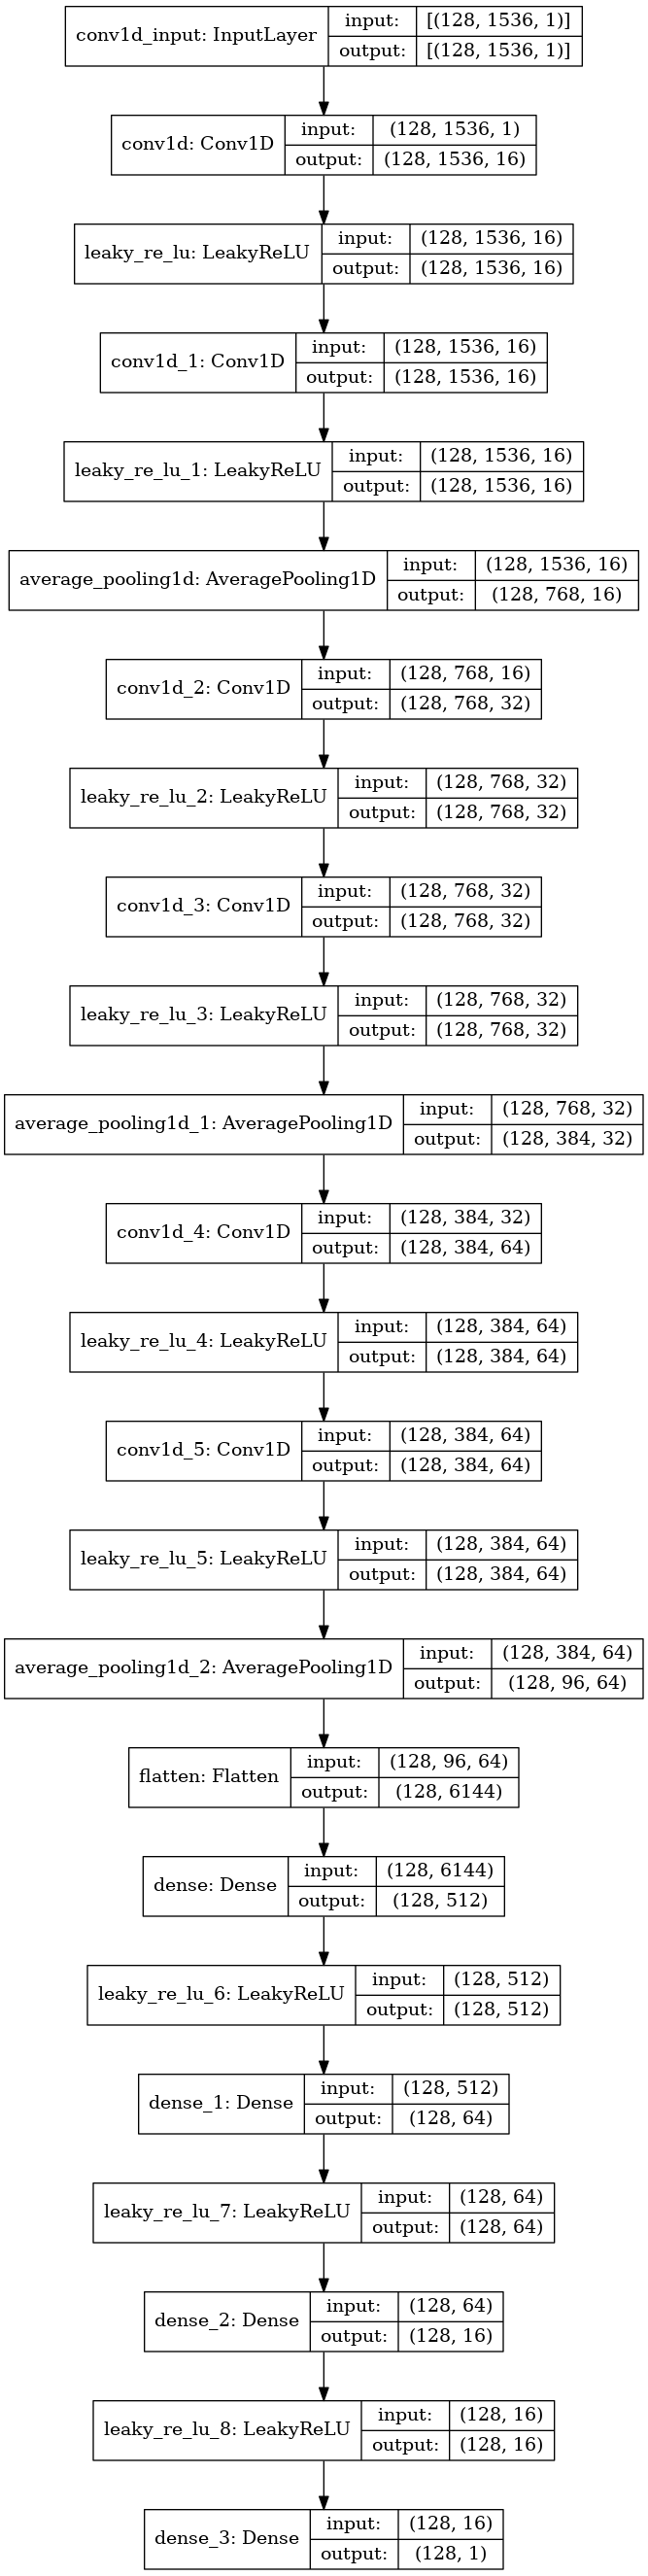

In [12]:
detector = define_detector(n_inputs=n_inputs,batch_size=batch_size)# build detector

# visualize detector architecture
detector.summary()
plot_model(detector, show_shapes=True, show_layer_names=True)

The detector model is now properly built and compiled for training.

### 4.3 The Generator Model
The generator model is also a sequentially built model. It is another fully-connected and convolutional neural network, like mentioned in this [paper](https://arxiv.org/pdf/1905.02417.pdf). However, this auto-correlation generator takes a slightly more simplified approach, in order to reduce computational cost and unnecessary layers (by removing some inital dense layers).

The generator model begins by taking an input `latent space` in one-dimension. This latent space is an assortment of random values drawn from the standard normal distribution (**citesection**) of a user-specified length. The objective behind this neural network generator (once trained) is to be able to produce a realistic auto-correlation from a normal-random noise vector (or latent space). This realistic auto-correlation, once the GAN's architecture, hyperparameters, and training are perfected, should be able to fool those at HERA who visually confirm that validity of auto-correlations (at least that is the objective). 

The first processing layer is a fully-connected `Dense` layer. It remaps the latent space to a certain desired amount of inputs (`n_inputs`). 

In order to fit the logical structure of the architecture, the `n_inputs` value must be divisble by 64, as the next layer reshapes the input tensor into two-dimensions of (n_inputs/64,64). 

The tensor is reshaped in order to fit the logic of the input structure of the following [transposed convolutional layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1DTranspose) (or deconvolution). The input shape follows the same form as the output of the convolutions in the detector. The first dimension is a compressed auto-correlation and the second is a feature map. The deconvolutions (represented by the Keras function, `Conv1DTranspose`) perform the inverse operation of a convolution/pooling combination, meaning the the feature/filter amount follows the opposite flow as well. The number of features start large and decrease the deeper the network gets. Simultaneously, the dimension that represents the channels of the fake auto-correlation increase with an inverse` stride` of `2` at each layer. 

The hyperparameters of the `Reshape` and `Conv1DTranspose` architecture are specifically designed for an output tensor of (1,1536) from the first `Dense` layer, as the result of the last deconvolution is a shape of (1536,1), which is the defining shape of the auto-correlation tensor in the detector model. Therefore, `n_inputs` is meant to be `1536`. The tensor is flattened to be compatible with the next dense layer. 

The last layer is a `Dense` layer that maps an input of 1536 to 1536. Although this may seem unintiuitve or computationally heavy (requires 1536<sup>2</sup> parameters), it is implemented to account for the reproduction of RFI channels. The RFI channels, typically being large spikes on one single frequency channel, proved a difficult task for exclusively deconvolutional layers to reproduce in preliminary network designs. The deconvolutions have a potential to miss extreme trends in data that do not span multiple frequency channels, as they hinge on the relationship between adjacent channels to produce a quality result. Although computationally more expensive than a deconvolution, the final `Dense` layer seems to potentially solve this problem, most likely serving as the layer that injects most, if not all RFI channels into the output fake auto-correlation (however, this cannot be proven due to the "hidden" nature of neural network decision-making). The layer can configure itself to greatly increase the magnitude of a single output channel through the use of matrix multiplication. 

The last layer used `LeakyReLU` activation, as the generator must be versatile in its ability to output auto-correlations. The generator is meant to produce auto-correlations of the same scale as the training set (which are typically on the scale of 10<sup>0</sup> and positive once normalized). This activation function can produce values within the range of the `REAL` auto-correlations with ease. It can also produce small negative numbers if necessary (this sometimes occurs when logarithmic normalization is used, s**ee section**).

The output is a (1536,1) tensor and is meant to increasingly resemble a plotted H4C auto-correlation as the model is trained.

#### 4.3.1. Compiling the Generator Model
The generator model is not compiled exclusively, as it is not trained on its own. In the next section **gansection**, the GAN is built. The generator is compiled within the GAN, as it trains based off of the performance the detector has when being fed `FAKE` auto-correlations that are flagged as `REAL` **see sec.1.2**. The generator does not use its own loss/accuracy results to train; therefore, not requiring exclusive compilation.

In [13]:
def define_generator(n_inputs,latent_dim,batch_size):
    """
    Build generator NN that produces a fake one-dimensional dataset at explicit linearly-spaced channels 
    (x-axis). It is designed to be trained on and produce fake HERA H4C auto-correlations.
    
    Arguments
    ---------
    n_inputs : integer
        Number of values in a single one-dimensional dataset 
    latent_dim : integer
        Number of latent dimensions for generator to create a dataset from
    batch_size : integer
        Number of datasets fed into generator at each training call
    
    Returns
    -------
    generator : tensorflow.python.keras.engine.sequential.Sequential
        Tensorflow keras sequentially-layered model 
    
    """
    
    # initialize a sequential neural network
    generator = Sequential(
        [
            
            Dense(n_inputs, input_shape=(1,latent_dim),batch_size=batch_size), # initial Dense layer with built-in input later
            LeakyReLU(alpha=0.2), # LeakyReLU activation function
            
            Reshape((int(n_inputs/64),64)), # reshape layer to more evenly distribute data in each dimension for the deconvolutional layers

            # first deconvolutional block
            Conv1DTranspose(32,5,padding='same',strides=2), # one dim. transposed convolutional layer
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(32,5,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            # second deconvolutional block 
            # notice that features and kernel size decrease the deeper into the model
            Conv1DTranspose(16,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(16,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
    
            # third deconvolutional block
            Conv1DTranspose(8,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(8,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            # final deconvolutional layer to reduce features to 1
            Conv1DTranspose(1,3,padding='same',strides=1),
            LeakyReLU(alpha=0.2),
            
            Flatten(), # flatten values to allow for mapping to a single dense layer
            
            Dense(n_inputs), # final dense layer, meant to help define RFI spikes seen in H4C auto-correlations
            LeakyReLU(alpha=0.2),
        
            Reshape((n_inputs,1)) # reshape output to be in the format of the detector model input
            
        ]
    )
    
    return generator # return generator model

#### 4.2.2. Building and Visualizing the Generator Model
The generator model reuses the same batch size as the detector to keep consistency. The input shape into the generator model is the length of the desired latent space to be used within the generator. In this case, it is `22`, which is motivated by a UC Berkley graduate student, Christian Bye (who provided advice and direction for this project). In his own machine-learning project, he used 22 latent dimensions and achieved success, so it was carried over for use in this project. More decisive decision into latent space size and assignment requires much more in-depth analysis and could be an area of **furtherwork** to perfect GAN training. The shape of the input latent space is (1,22), so that the `Dense` layers can perform computations on the latent values. The other input, `n_inputs` represents the number of neurons to map to for two of the `Dense` layers in the generator architecture. This input is designed to reflect the number of desired frequency channels to be produced in the output, which is `1536`.

In [14]:
latent_dim = 22; # length of desired latent space for input into the generator model
# n_inputs and batch_size variables are reused from the define_detector() function call

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (128, 1, 1536)            35328     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (128, 1, 1536)            0         
_________________________________________________________________
reshape (Reshape)            (128, 24, 64)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (128, 48, 32)             10272     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (128, 48, 32)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (128, 96, 32)             5152      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (128, 96, 32)            

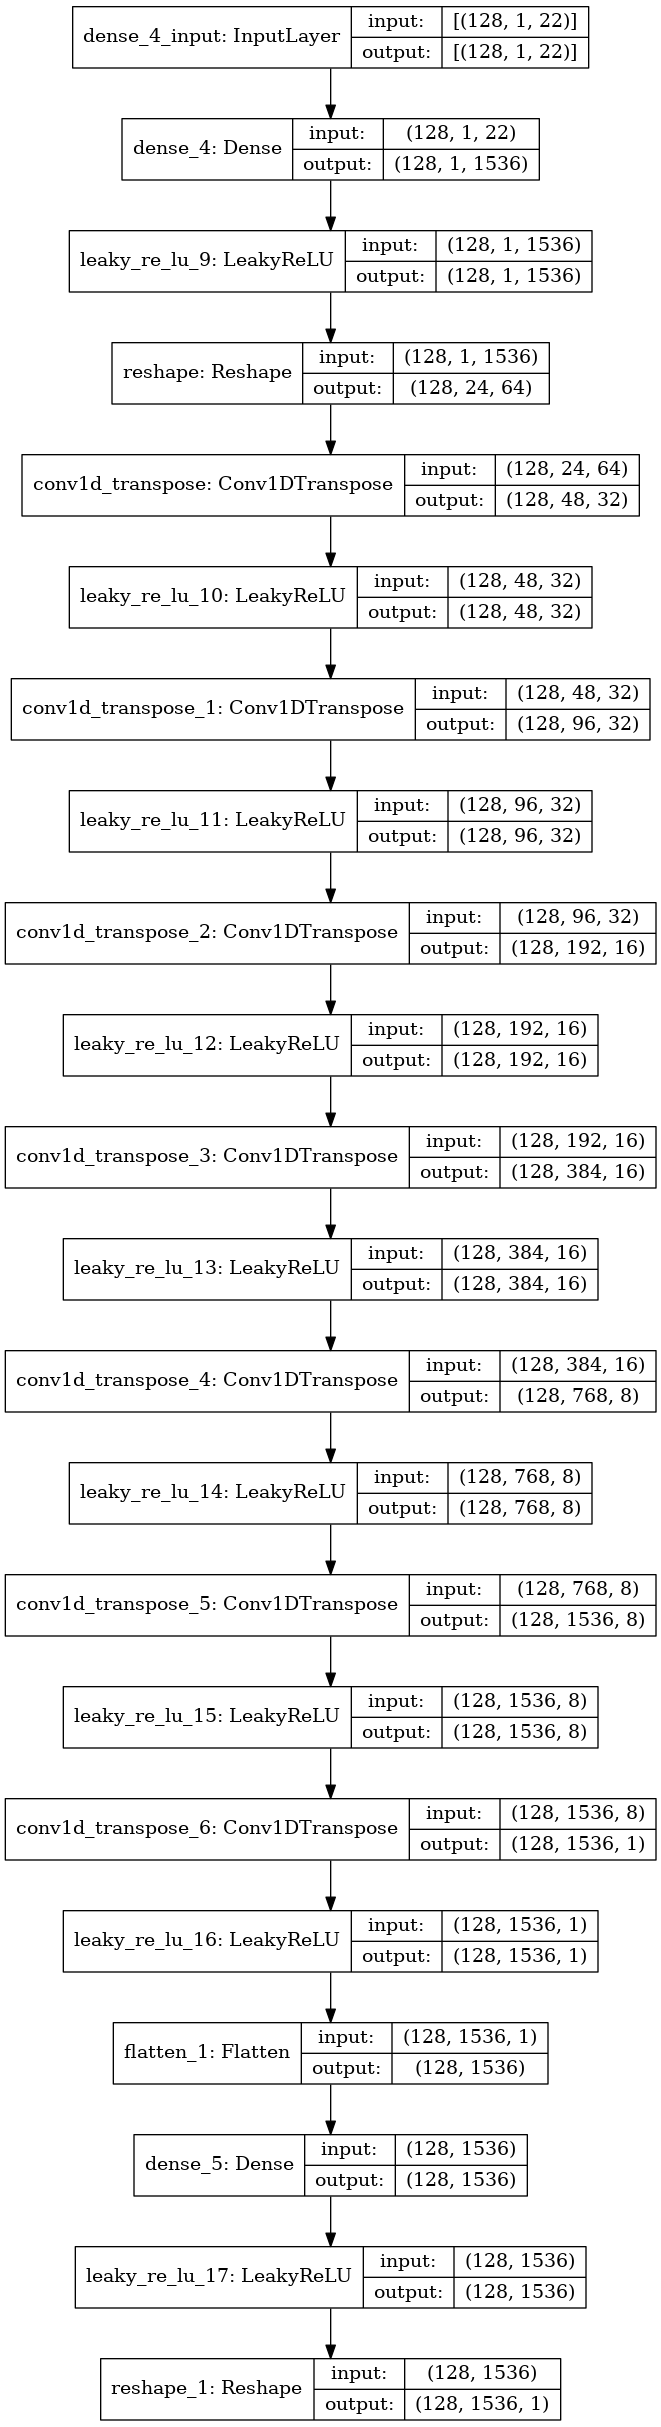

In [15]:
generator = define_generator(n_inputs=n_inputs,latent_dim=latent_dim,batch_size=batch_size) # build generator

# visualize generator architecture
generator.summary() 
plot_model(generator, show_shapes=True, show_layer_names=True)  

The generator model is now built and ready for compilation within the GAN.

### 4.4 The GAN Model
The GAN model architecture differs from the generator and detector models in two very different ways:
1. The model is not sequential. It is built as a [functional API](https://keras.io/guides/functional_api/).
2. The model contains other models (the generator and detector) within it.

The GAN model is an overarching combination of both the generator and detector models. One input takes the shape of the generator's input, because the generator model is one of the initial layers in the GAN model pipeline. However, there are actually two initial layers. This is what defines a functional API model in Keras. It is not sequentially built, meaning the output tensor of the layer above is not automatically the input tensor for the next. Instead, the input tensor must be specified. With this functionality, the model is now open to have outputs of layers saved and called in later layers non-consecutively. This capability enables the model to apply one-centered gaussian noise (with a standard distribution based from the Radiometer Equation) to the generator's fake auto-correlation output. **See section,link later**. The output from the [`Gaussian Noise`](https://keras.io/api/layers/regularization_layers/gaussian_noise/) and the output from the generator model are combined through the [`Multiply`](https://keras.io/api/layers/merging_layers/multiply/) layer, which multiplies two input tensors to one output tensor output. The output from this layer should resemble an auto-correlation with realistic noise at each measured frequency channel. This tensor is inserted into the detector model, where the output is a binary classification. 

It is important to note that the detector is flagged as [untrainable](https://keras.io/guides/transfer_learning/). This will come into play when discussing the training of the GAN.

#### 4.4.1. Compiling the GAN Model
The GAN model is compiled for training the same as the detector model is. This is done because the output of the detector is the output of the GAN model. This means `binary cross-entropy` is best as the loss function. The optimizer remains as `ADAM`, as this has been proved to be a viable optimizer for GANs. However, the accuracy metric is not necessary, as the input auto-correlations into the GAN's detector model will be falsely flagged (see **section** for more details).

In [16]:
def define_gan(generator, detector, stddev, latent_dim, batch_size, n_inputs):
    """
    Build Generative Adversarial NN that updates generator model weights based 
    off of detector results of fake data with a REAL flag pairing.
    
    Arguments
    ---------
    generator : tensorflow.python.keras.engine.sequential.Sequential
        Tensorflow keras model that creates fake data
    detector : tensorflow.python.keras.engine.sequential.Sequential
        Tensorflow keras model that delinates between real and fake data
    stddev : float
        Standard deviation (derived from the Radiometer Eqn.) defined by HERA H4C measurement sensitivities/properties
    latent_dim : integer
        Number of latent dimensions for generator to create a dataset from
    batch_size : integer
        Number of datasets fed into GAN at each training call
    n_inputs : integer
        Number of values in a single one-dimensional dataset 
    
    Returns
    -------
    GAN : tensorflow.python.keras.engine.sequential.Sequential
        Tensorflow keras model that combines an untrainable detector with a trainable generator
    
    """
    detector.trainable = False # make detector weights not trainable, only need detector results in order to update the generator
    
    inp = Input(shape=(1,latent_dim)) # input layer for creating an input tensor for the generator model
    gen_layer = generator(inp) # generator model layers
    noise = GaussianNoise(stddev=stddev)(tf.ones((batch_size,n_inputs,1))) # create one-centered gaussian noise 
    mult_layer = Multiply()([gen_layer,noise]) # multiply generator output with radiometer noise 
    det_layer = detector(mult_layer) # feed multiply output into detetor
    GAN = tf.keras.Model(inputs=inp, outputs=det_layer) # define Functional API model
    
    GAN.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5)) # compile detector model
    
    return GAN # return GAN model

#### 4.4.2. Building and Visualzing the GAN Model
The pre-built `generator` and `detector` models are two necessary inputs for building the GAN. They are called within the GAN model. The GAN reuses a batch size of `128` for consistency. The `latent_dim` is equivalent to that of the generator model, as the GAN uses the same generator parameters as when it was built by itself. `n_inputs` is `1536` as it was in the previous models. This number is required as an input to define the noise vector that is factored into the generator output. Lastly, `stddev` is the standard deviation calculated in **cite section** and is required for the noise application within this model. 

**All inputs into `define_gan()` are defined within cells above.**

In [17]:
gan = define_gan(generator=generator, detector=detector, stddev=stddev, latent_dim=latent_dim,  
                      batch_size=batch_size, n_inputs=n_inputs) # build GAN model

gan.summary() # visualize GAN model
# plot_model(gan, show_shapes=True) FIGURE OUT HOW TO PLOT

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 22)]           0         
_________________________________________________________________
sequential_1 (Sequential)    (128, 1536, 1)            2414537   
_________________________________________________________________
multiply (Multiply)          (128, 1536, 1)            0         
_________________________________________________________________
sequential (Sequential)      (128, 1)                  3231857   
Total params: 5,646,394
Trainable params: 2,414,537
Non-trainable params: 3,231,857
_________________________________________________________________


The GAN is now built and ready for compilation for training.

## 5. Training the Models

This section contains all functions and calls required for training the GAN, detector, and generator models. It also includes all the pre-processing functions required for preparing `REAL` and `FAKE` data for training.

### 5.1 Pre-processing and Preparing Data Sets
The following functions are to be called within the larger `train()` function, which will be described further below. These functions normalize and organize both the `REAL` and `FAKE` data. They also create the classification vectors that are fed into the training function in order to specify what the input training data is (`REAL` or `FAKE`). 

#### 5.1.1. Generate `REAL` Training Batches
The function below serves three purposes:
1. Concatenate a batch of `REAL` auto-correlations (from `data` input) of a desired `batch_size`
2. Normalize the data within the batch by a desired normalization technique (`norm_tech`)
3. Create a `REAL` classification array of length `batch_size`

Normalization pre-processing of the training set is important to perform on the auto-correlation data. In some auto-correlation data, dependent on the current technique of HERA's correlator, RFI channel magnitudes may differ significantly from the rest of the auto-correlation. Neural networks, as seen in preliminary drafts of these models, had difficulty training to these intense magntiude spikes. It is possible for these primarily convolutional neural networks to train to these large spikes, but it was seen to take significantly longer to train. This would make the development/improvement of network architectures and hyperparameters difficult to do quickly. However, normalization can solve this problem, by decreasing the scale of these training auto-correlations. 

Three types of normalization options are possible with the function below:
1. Median Normalization: normalize by dividing data by the auto-correlation median
2. Natural Logarithmic Normalization: normalize by taking the natural logarithm of the auto-correlations
3. Fixed-Point Normalization: normalize by dividing data by a fixed input 

Once the data is normalized and organized into a batch. It is input into the detector for training.

A comparison of normalization techniques will be given later within this report. 

In [18]:
def generate_real_values(batch_size,data,norm_tech):
    """
    Grabs real auto-correlations from loaded in HERA data and organizes into batches for NN model training.
    
    Arguments
    ---------
    batch_size : integer 
        Number of auto-correlations fed into a model at each training call
    data : numpy array
        HERA auto-correlation data
    norm_tech : string or float
        Determines which normalization technique to use for the data
    
    Returns
    -------
    X : numpy array
        Batch of auto-correlations; first dimension associates to a specific dataset in larger batch/second dimension is a single dataset of values output from HERA auto-correlation data at specific fequency channels
    Y : numpy array
        Batch of "1" classification flags; first dimension associates to a specific dataset in larger batch/second dimension indicates to the detector model that the values are flagged as "real" data
    
    """
    X = [] # initialize data set
    
    # grab random, real auto-correlations for the desired batch size
    for ii in range(batch_size):
        
        signal = data[np.random.randint(1,len(data)+1)-1].real # call a random auto-correlation from array
        
        if norm_tech == 'median': # median normalization
            sig_norm = signal/np.median(signal) 
        elif norm_tech == 'log': # natural logarithmic normalization
            sig_norm = np.log(signal)
        else: # fixed-point normalization
            sig_norm = signal/norm_tech
        
        X.append(sig_norm) # append to batch
 
    X = np.array(X) # convert list to numpy array
    X = X.reshape((batch_size,1536,1)) # reshape to agree with keras convolutional layer input standard
    Y = np.ones((batch_size,1)) # associated real flags for each retrieved auto-correlation

    return X, Y # return data sets

#### 5.1.2. Organize Validation Data Set
This function normalizes the validation set that was created in **citesection**. It can also be used to normalize the test set. The normalization techniques are the same as the function above. The same technique is used on the training, validation, and testing set that are associated to the same model training run or results will be inconsistent. 

The validation set is key in analyzing the training of the model. It allows insight into whether the models are being overfit to the current training set. The validation set is kept separate from the training set and is never used for model training. This means the detector model will never be influenced by the validation data. In theory, when comparing the losses/accuracies of the detector has for validation and training set at each epoch, they should be equivalent. This is because both sets represent the same classification and are randomly selected. 

In the case that the validation set and training set return performance data that significantly differ from one another, the model training process may have a flaw. The most common flaw is overfitting of the training set. This means that the detector model over trains to the training set and loses its ability to detect a good, random auto-correlation. It possibly trained itself to idetify a trend only seen in the training set and is not indicative of any `REAL` auto-correlation. This can be seen with the accuracy of detection decreasing for the validation set as the accuracy of detection for the training set increasing or remaining the same over many epochs. Validation sets are essential for anlayzing the useability for GANs. 

In [19]:
def generate_validation(val_data, norm_tech):
    """
    Generates normalized validation data set of auto-correlations.
    
    Arguments
    ---------
    val_data : numpy array
        Raw auto-correlation validation array; shape is (# of signals, frequencies)
    norm_tech : string or float
        Determines which normalization technique to use for the data
    
    Returns
    -------
    X : numpy array
        Normalized and reshaped auto-correlation validation array, shape is (# of signals, frequencies, 1)
    Y : numpy array
        Batch of "1" classification flags; first dimension associates to a specific dataset in larger batch/second dimension indicates to the detector model that the values are flagged as "real" data

    """
    
    # iterate through each auto-correlation to apply normalization
    for ii in range(len(val_data)):
        
        if norm_tech == 'median': # median normalization
            val_data[ii] = (val_data[ii].real/np.median(val_data[ii].real))
        elif norm_tech == 'log': # logarithmic normaliation
            val_data[ii] = np.log(val_data[ii].real) 
        else: # fixed-point normalization
            val_data[ii] = (val_data[ii].real/norm_tech)
            
    X = val_data.reshape((len(val_data),len(val_data[0]),1)) # reshape data to be compatible with the detector model
    Y = np.ones((len(X),1)) # create "1" classification array to accompany validation set
    
    return X, Y # return validation data sets

#### 5.1.3. Generate `FAKE` Data Batches
The `generate_latent()` function below creates a latent space array of a certain length (`latent_dim`) and certain size (`batch_size`). The latent space has its values drawn from the standard normal distribution **cite section**. It is used as the input batch into the generator when producing `FAKE` auto-correlations.

In [20]:
def generate_latent(latent_dim, batch_size):
    """
    Generate latent noise arrays for input into the generator model and use in the generate_fake() function.
    
    Arguments
    ---------
    latent_dim : integer
        Number of latent dimensions for generator to create a dataset from
    batch_size : integer 
        Number of auto-correlations fed into a model at each training call
    
    Returns
    -------
    x_input : numpy array 
        Latent space noise array; First dimension corresponds to a specific batch/second dimension are the randomly generated latent values for a specific batch
    
    """
    
    x_input = np.random.randn(batch_size,1,latent_dim) # create a latent space noise array from values grabbed from the stanrdard normal distribution
    
    return x_input # return the latent space

The `generate_fake()` function inputs a latent space of a certain `batch_size` into the generator. The generator then outputs its `FAKE` data. It creates as many auto-correlations as the defined `batch_size`. These auto-correlations may look realistic, depending on how far the models are into training. It also returns  `FAKE` classification flags for each generate auto-correlation. These outputs are to be used in training the detector. 

In [21]:
def generate_fake(generator, latent_dim, batch_size):
    """
    Generates a fake datasets to be fed into the detector for training.
    
    Arguments
    ---------
    generator : tensorflow.python.keras.engine.sequential.Sequential
        Tensorflow keras model that creates fake auto-correlation data
    latent_dim : integer
        Number of latent dimensions for generator to create a dataset from
    batch_size : integer 
        Number of auto-correlations fed into a model at each training call
    
    Returns
    -------
    X : numpy array
        Fake auto-correlation batch; first dimension associates to a specific dataset in larger batch/second dimension is a single dataset of fake values (corresponding to "x_inputs" from "generate_real_values" function) output from the generator 
    Y : numpy array
        Batch of "0" classification flags; first dimension associates to a specific dataset in larger batch/second dimension indicates to the detector model that the values are flagged as "fake" data
    
    """
    
    x_input = generate_latent(latent_dim, batch_size) # generate a latent space for generator
    X = generator.predict(x_input,batch_size) # create fake auto-correlations of a specific batch_size
    Y = np.zeros((batch_size,1)) # create "fake" classification array
    
    return X, Y # return "fake" training data

### 5.2 Training Function

#### 5.2.1. Training Methodoolgy
GANs require a specific training scheme in order to train both the detector and generator models properly. The breakdown is as follows.

The detector is trained exclusively (as it is untrainable within the GAN model). That is why it is given the ability to be compiled by itself. At each epoch, the detector is fed a batch of `REAL` auto-correlations with `REAL` flags and a batch of `FAKE` auto-correlations with `FAKE` flags. The detector trains by using Keras [`train_on_batch`](https://keras.io/api/models/model_training_apis/) function. This function allows the manual training of a model at each epoch, rather than using a function that automates the process and trains for multiple epochs with one function call (the [`fit`](https://keras.io/api/models/model_training_apis/) function does this). This function is a necessity, as after each epoch, the generator will be capable of producing more realistic `FAKE` auto-correlations. The training function must be iterable in order to insert better `FAKE` batches at each epoch. Therefore, the detector will get increasingly better at detecting `FAKE` auto-correlations that increasingly resemble `REAL` auto-correlations as training proceeds. To note, the training is separate for `REAL` and `FAKE` values due to trial and error. Training the detector separately on these batches saw faster training than if they were combined.

The generator is trained through the GAN model. The GAN model uses `train_on_batch` as well, for the same reason the detector does. The training is not as straightforward as the detector training may seem. The input batch for training the GAN consists of a `latent space` of a specific batch size, along with an identifier list of `REAL` of the same batch size. The latent space is fed into the GAN architecture, which means the values are fed into the generator first. The generator produces a `FAKE` auto-correlation, which is multiplied by the Radiometer noise (**see section blah**). This new `FAKE` auto-correlation, with noise accounted for, is input into the detector architecture. The detector, which is untrainable in this architecture, will output a classification (0 or 1) for what it thinks these `FAKE` auto-correlations are (either `REAL` or `FAKE`). Then the loss will be calculated based from the comparison between comparison of the detector's classification and the `REAL` flags associated to the generator's auto-correlations. The loss value from the detector is what influences the training of the weights of the generator. The generator trains on `FAKE` data that is labelled as `REAL`, because the generator's goal is to create the auto-correlations that trick the generator. So, for example, if the loss value is high for the GAN training, the generator did not do well tricking the detector (as large loss points to disagreement between input flags and detector output classifcations). If the loss value is low, the generator did well at tricking the detector and does not need to update its weights as much.

This dual-training leads to a zero-sum game. The generator is constantly improving, as it uses the detector's performance to update itself. The detector is constantly improving, as it is fed more and more realistic `FAKE` data. The result should be a generator that can produce realistic auto-correlations that can trick the manual observer and a detector that can detect even the slightest deviation from a proper auto-correlation (in order to detect possible, unseen malfunctions in antennas). 

#### 5.2.2. Training Function Breakdown
The training function not only trains the models, but it also shows its progress during training and saves/presents performance data. 

All data pertaining to the training of a GAN is saved to the `final_training-analysis` directory, where different runs can be found (which will be labelled depending on the normalization technique used). 

All data stored within has a READ-ME to describe them.

In [22]:
import h5py # use for organization and export of loss/accuracy data for model training
import os # use for saving and creating directories and files

In [23]:
def train(generator, detector, gan, latent_dim, n_inputs, data, val_data, freqs, batch_size, 
          dir_name, filepath_to_save, n_epochs=5000, n_show_snap=1000, n_save_model=500, n_save_snap=50,
          ratio=1, save_run=False, date_time='', model_comments='', reference_notes='', run_num='', commit='',
          norm_tech='median'):
    """
    Trains the detector for delinating between real and increasingly more realistic fake values. 
    Trains the generator to produce more realistic fake data. 
    Also, saves helpful summary/analysis files for model-training analysis. 
    
    Arguments
    ---------
    generator : 
        Tensorflow keras model that creates fake data
    detector : 
        Tensorflow keras model that delinates between real and fake data
    gan : 
        Tensorflow keras compiled model that combines generator and detector into a GAN
    latent_dim : integer
        Number of latent dimensions for generator to create a dataset from
    n_inputs : integer
        Amount of values in a single one-dimensional dataset
    data : numpy array
        HERA auto-correlation data
    val_data : numpy array
        Array of auto-correlations separated from training set for use in model validation (pre-normalized)
    freqs : numpy array
        Array of frequencies for H4C auto-correlationd data
    batch_size : integer
        Number of datasets fed into detector at each training call
    dir_name : string
        Name of directory to save keras models, epoch-progression plots, and analysis plots
    filepath_to_save : string 
        Filepath to directory to where training run data will be saved to 
    n_epochs : integer
        Total number of epochs for function training
    n_show_snap : integer
        Number of epochs between showing a snapshot of generator output within notebook
    n_save_model : integer
        Number of epochs between model saves
    n_save_snap : integer
        Number of epochs between epoch generator ouput snapshot saves
    ratio : integer
        Ratio of GAN to detector training calls at each epoch
    save_run : boolean
        Save training data option; save run == True, do not save run == False
    date_time : string
        Date and time of training execution
    model_comments : string
        Any comments about the current keras models to be input into the overarching READ-ME
    reference_notes : string
        Any comments about the currnt operating notebook this function is ran in and what data is being used to train with
    run_num : string 
        Current training run identification number
    commit : string
        Current commit that the model is trained from
    norm_tech : string or float
        Determines which normalization technique to use for the data

    Returns:
    None
    
    """
    # if saving training data is desired
    if save_run == True:
        
        dir_path = os.path.join(filepath_to_save, dir_name) # create general filepath/directory for saved data
        os.mkdir(dir_path)
        
        epoch_dir_path = os.path.join(dir_path, 'training-snapshots') # filepath/directory creation for epoch progress plots
        os.mkdir(epoch_dir_path)

        perf_dir_path = os.path.join(dir_path, 'training-performance') # filepath/directory creation for performance analysis files (ie. loss and accuracy)
        os.mkdir(perf_dir_path)
        
        model_dir_path = os.path.join(dir_path, 'model-save') # filepath/directory creation for performance analysis files (ie. loss and accuracy)
        os.mkdir(model_dir_path)
        
        # create and append READ-ME for current run
        with open(os.path.join(dir_path,'READ-ME_training-details.txt'),'w+') as f:
            f.write('HERA Auto-Correlation GAN Training Run ID-{} \n'.format(run_num))
            f.write('Time of Execution: {} \n'.format(date_time))
            f.write('Code written and ran by Joseph C. Shy \n')
            f.write('Code executed from Commit - {}. Neural Network inputs are documented below. \n\n'.format(commit))
            f.write("The folder 'training-snapshots' contains random generator output every {} epochs. \n".format(n_save_snap))
            f.write("The folder 'training-performance' shows various losses and accuracies of the model training. They can be used to analyze the validity and fit of the models created.\n\n")
            f.write('Manually Input Comments\n{}\n\n\n'.format('-'*23))
            f.write('Data and Code Version Reference \n{}{}\n\n'.format('-'*32,reference_notes))
            f.write('Training/Model Comments \n{}'.format('-'*23))
            f.write('{} \n\n'.format(model_comments))
            f.write('Training Input Parameters: \n{}\n'.format('-'*26))
            f.write('Latent Dimensions = {} \nFrequency Channels = {} \nTotal Epochs in this run = {} \nBatch Size = {} \nGan-to-Detector Training Ratio per Epoch = {} \n\n'.format(latent_dim, n_inputs, n_epochs, batch_size, ratio))
            f.write("The '.h5' files contain the final models and their weights after the last epoch of training. The directory, 'model-save' contains trained models from every {} epochs (in case future work is done with intermediate models or model overfits after a certain amount of epochs), but it is not tracked in the Github associated. \n".format(n_save_model))
            f.write("The '*_summary.txt' files are the summaries of the layers of each model seen as a result of the command 'model.summary()'. \n")
            f.write("The '*_visual.png' files are the flow chart plots of the layers of each model. It is helpful, as it includes the input shape of each model (while the '*_summary.txt' does not).")
            f.write(' The flow chart for the GAN is not present, as it its architecture is not compatible with the function that produces the visuals. \n\n')   
            f.write("All directories (aside from 'model-save') contain their own READ-ME files.")
            
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist, v1_hist, v1_acc = [],[],[],[],[],[],[] # initalizing loss and accuracy lists
    # d1_hist = detector training real value loss
    # d2_hist = detector training fake value loss
    # g_hist = gan fake training loss
    # a1_hist = detector training real value accuracy
    # a2_hist = detector training real value accuracy
    # v1_hist = detector validation set loss
    # v1_acc = detector validation set accuracy
    
    # iterate through range of epochs and train detector and gan
    for ii in range(n_epochs):
       
        # train detector
        x_real, y_real = generate_real_values(batch_size=batch_size, data=data, norm_tech=norm_tech) # grab real data
        x_fake, y_fake = generate_fake(generator=generator, latent_dim=latent_dim, batch_size=batch_size) # generate fake data
        loss_real, acc_real = detector.train_on_batch(x_real, y_real) # train detector on real data
        loss_fake, acc_fake = detector.train_on_batch(x_fake * np.random.normal(loc=1,scale=stddev,size=(batch_size,n_inputs,1)), y_fake) # train detector on generated fake data with noise
       
        # get perforamance results of validation data 
        x_val = val_data
        y_val = np.ones(np.shape(val_data))
        loss_val, acc_val = detector.test_on_batch(x_val, y_val)
        
        # train GAN
        # if GAN:detector training ratio is desired, new for loop is entered
        for jj in range(ratio):
            x_gan = generate_latent(latent_dim=latent_dim, batch_size=batch_size) # generate latent dimensions for gan training
            y_gan = np.ones((batch_size,1)) # create false identifiers for fake data to trick gan
            gan_loss = gan.train_on_batch(x_gan, y_gan) # train gan with falsely identified fake data]
            g_hist.append(gan_loss) # append loss to list

        # based on epoch interval desired progress benchmarks, psavegenerator output snapshots
        if (ii+1) % n_save_snap == 0 or ii == 0:
                        
            # plot random real and fake data
            fig = plt.figure(dpi=150)
            plt.plot(freqs*1e-6, x_real[0,:,0], color='red',label='Real')
            plt.plot(freqs*1e-6, x_fake[0,:,0], color='blue',label='Fake')
            plt.title('Auto-Correlation @ Epoch: {}'.format(ii+1))
            plt.xlabel('Frequency [MHz]')
            plt.ylabel('Uncalibrated Power')
            plt.legend()
            
            # based on epoch interval desired progress benchmarks, psavegenerator output snapshots
            if ((ii+1) % n_show_snap == 0 or ii == 0):
                print('Epoch: {} \nTraining Data - Acc_Real: {} | Acc_Fake: {}\nValidation Data - Acc: {}'.format(ii+1, acc_real, acc_fake, acc_val)) # print evaluation results
                plt.show()
           
            # save plot if desired
            if save_run == True:
                fig.savefig(os.path.join(epoch_dir_path,'generator-output_epoch-{}.png'.format(ii+1)),dpi=200)
                plt.close()
                
                # if saving models is desired, save at certain epoch intervals
                if ((ii+1) % n_save_model == 0 or ii == 0):
                    model_subpath = os.path.join(model_dir_path,'model_ID-{}_epoch{}'.format(run_num,ii+1))
                    os.mkdir(model_subpath)
                    detector.save(os.path.join(model_subpath,'detector_ID-{}_epoch-{}.h5'.format(run_num, ii+1)),overwrite=True)
                    generator.save(os.path.join(model_subpath,'generator_ID-{}_epoch-{}.h5'.format(run_num, ii+1)),overwrite=True)
                    gan.save(os.path.join(model_subpath,'gan_ID-{}_epoch-{}.h5'.format(run_num, ii+1)),overwrite=True)
                
        
        # append analysis values to list
        d1_hist.append(loss_real)
        d2_hist.append(loss_fake)
        a1_hist.append(acc_real)
        a2_hist.append(acc_fake)
        v1_hist.append(loss_val)
        v1_acc.append(acc_val)
            
    # at end of training, plot loss and accuracy values over the training process
    
    # training/validation losses from detector
    fig1 = plt.figure(dpi=200)
    plt.plot(d1_hist, label='Training')
    plt.plot(v1_hist, label='Validation')
    plt.legend()
    plt.title('Detector Loss - Real Values')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.show()
    
    # detector loss for fake
    fig2 = plt.figure(dpi=200)
    plt.plot(d2_hist)
    plt.title('Detector Loss for Fake Values')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.show()
    
    # GAN loss
    fig3 = plt.figure(dpi=200)
    plt.plot(g_hist)
    plt.title('Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.show()
    
    # training and validation accuracies from detector
    fig4 = plt.figure(dpi=200)
    plt.plot(a1_hist,label='Training')
    plt.plot(v1_acc, label='Validation')
    plt.legend()
    plt.title('Detector Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    # detector accuracy for fake values
    fig5 = plt.figure(dpi=200)
    plt.plot(a2_hist)
    plt.title('Detector Accuracy for Fake Values')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
    ## CREATE SAVE PATH
    # if saving is desired, save analysis plot, plot documentation, performance data, and trained models 
    if save_run == True:
        
        # create a READ-ME for snapshot plots
        with open(os.path.join(epoch_dir_path,'READ-ME_training-snapshots.txt'),'w+') as f:
            f.write('HERA Auto-Correlation GAN Training Run ID-{} \n'.format(run_num))
            f.write('Time of Execution: {} \n'.format(date_time))
            f.write('Code written and ran by Joseph C. Shy \n')
            f.write('Code executed from Commit - {} \n'.format(commit))
            f.write('{} \n\n'.format('-'*50))
            f.write('This directory contains a random generator output overlaid atop a random REAL auto-correlation. \n')
            f.write('Each plot marks 25 training epochs of progress. It ranges from 1 epoch of training to {}'.format(n_epochs))
        
        # create a READ-ME for performance data
        with open(os.path.join(perf_dir_path,'READ-ME_training-performance.txt'),'w+') as f:
            f.write('HERA Auto-Correlation GAN Training Run ID-{} \n'.format(run_num))
            f.write('Time of Execution: {} \n'.format(date_time))
            f.write('Code written and ran by Joseph C. Shy \n')
            f.write('Code executed from Commit - {}'.format(commit))
            f.write('This directory contains performance data that can be used to analyze the model training run. \n\n')
            f.write("The '.hdf5' file contains numerical performance data returned after each training epoch. It has the following attributes: ['units', 'description', 'link']. The structure of the file is below: \n")
            f.write("""
            Group - 'training-loss' : loss is unitless (as a result of binary cross-entropy/log loss)
                dataset - 'det_real' : contains the detector loss at each epoch from the REAL training set
                dataset - 'det_fake' : contains the detector loss at each epoch from the FAKE training set (grabbed from generator at each epoch)
                dataset - 'det_validation' : contains the detector loss at each epoch from the REAL validation set (data that is not used to train)
                dataset - 'gan_fake' : contains the GAN loss at each epoch from the FAKE training set that is paired with REAL flags (for GAN training)
            
            Group - 'training-accuracy' : accuracy is unitless (fraction of correctly identified inputs divided by total number of inputs in batch)
                dataset - 'det_real' : contains the detector accuracy at each epoch from the REAL training set
                dataset - 'det_fake' : contains the detector accuracy at each epoch from the FAKE training set (grabbed from generator at each epoch)
                dataset - 'det_validation' : contains the detector accuracy at each epoch from the REAL validation set (data that is not used to train)""")
            f.write('\n\nThe plots within this directory are graphical representations of the data described above. \nThe REAL training and validation set losses/accuracies are paired together on plots to check for divergence that could signify overfitting.')
        
        # save performance plots
        fig1.savefig(os.path.join(perf_dir_path,'detector-loss_real_and_validation.png'),dpi=300)
        plt.close()
        fig2.savefig(os.path.join(perf_dir_path,'detector-loss_fake.png'),dpi=300)
        plt.close()
        fig3.savefig(os.path.join(perf_dir_path,'generator-loss.png'),dpi=300)
        plt.close()
        fig4.savefig(os.path.join(perf_dir_path,'detector-accuracy_real_and_validation.png'),dpi=300)
        plt.close()
        fig5.savefig(os.path.join(perf_dir_path,'detector-accuracy_fake.png'),dpi=300)
        plt.close()
           
        # save final model, model visual, and model summary
        detector.save(os.path.join(dir_path,'detector_ID-{}_epoch-{}.h5'.format(run_num, ii+1)),overwrite=True)
        plot_model(detector, show_shapes=True, show_layer_names=True, to_file=os.path.join(dir_path,'detector_visual.png')) ## NAME: detector_visual.png
        with open(os.path.join(dir_path,'detector_summary.txt'), 'w') as f:
            detector.summary(print_fn=lambda x: f.write(x + '\n'))
                  
        generator.save(os.path.join(dir_path,'generator_ID-{}_epoch-{}.h5'.format(run_num, ii+1)),overwrite=True)
        plot_model(generator, show_shapes=True, show_layer_names=True, to_file=os.path.join(dir_path,'generator_visual.png'))
        with open(os.path.join(dir_path,'generator_summary.txt'), 'w') as f:
            generator.summary(print_fn=lambda x: f.write(x + '\n'))
                  
        gan.save(os.path.join(dir_path,'gan_ID-{}_epoch-{}.h5'.format(run_num, ii+1)),overwrite=True)
        with open(os.path.join(dir_path,'gan_summary.txt'), 'w') as f:
            gan.summary(print_fn=lambda x: f.write(x + '\n')) 
        
        # save an hdf5 file containing all performance data
        with h5py.File(os.path.join(perf_dir_path,'GAN-training_performance.hdf5'), 'w') as f:
            
            loss = f.create_group('training-loss')
            loss.create_dataset('det_real', data=d1_hist)
            loss.create_dataset('det_fake', data=d2_hist)
            loss.create_dataset('det_validation', data=v1_hist)
            loss.create_dataset('gan_fake', data=g_hist)
            # add attributes
            loss.attrs['units'] = 'unitless'
            loss.attrs['description'] = 'loss values calculated from binary cross-entropy/log loss'
            loss.attrs['link'] = 'For more info: https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-function'
            
            acc = f.create_group('training-accuracy')
            acc.create_dataset('det_real', data=a1_hist)
            acc.create_dataset('det_fake', data=a2_hist)
            acc.create_dataset('det_validation', data=v1_acc)
            # add attributes
            acc.attrs['units'] = 'unitless'
            acc.attrs['description'] = 'accuracy values calculated as (fraction of correctly identified inputs/total input batch size)'
            acc.attrs['link'] = 'For more info: https://keras.io/api/metrics/accuracy_metrics/'       

## 6. Model Training
Below are the function calls and variable assignment for training various GAN models. The training will differ dependent on the pre-processing normalization technique of the training/validation sets. Differing techniques are used to compare the efficiencies in training (by seeing how well each model trains and tests after a set `10,000` epochs of training. `10,000` epochs of training is cbosen arbitrarily but kept consistent to compare models. The same analysis (ie. testing if the model detects bad auto-correlations as `FAKE` data) will be done on each model in order to help determine which normlaiztion technique trained the model the most efficiently and reliably. 

### 6.1. Median Normalization Training
The following training is for `median` normalization method of pre-processing the training and validation auto-correlations. The directory `model_ID-1` will pertain to the training data and performance of the `median` training run. 

In [24]:
# n_inputs, latent_dim, and batch_size are pre-defined

# training/analysis variables
n_epochs = 10000 # number of epochs for model building
ratio = 1 # ratio of GAN to detector training per epoch
norm_tech = 'median' # normalization technique


# file save variables
n_save_snap = 50 # when to present a plot
n_save_model = 500 # when to save a model
n_show_snap = 500 # when to show a snapshot
save_run = True # boolean to determine whether or not a save run is required 
run_num = '1' # run identification
dir_name = 'model_ID-{}'.format(run_num) # directory name for current model and training analysis results
filepath_to_save = '/users/jshy/mylustre/machine_learning/2459122-H4C_Machine-Learning_Practice/final_training-analysis'# directory in which to save folders to for current models 
date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S") # current date and time
commit = '3f08113ada0ec80f146166889552bcca26eb9a65'

model_comments = '''
This is a training run of the auto-correlation training on the "ee" data from night of 2459122.
It is a final run, using the median pre-processing technique. 
Please refer to 'HERA-GAN_joseph-shy_memo.ipynb' jupyter notebook for details into the model architectures/hyperparameters.
'''

reference_notes = '''
The notebook used to generate this model is 'HERA-GAN_joseph-shy_memo'.
The auto-correlation ("ee") training set was randomly chosen from all good antennas flagged on the night of 2459122 for all integration time files located in the H4C directory in HERA lustre. 
Reference the text files in the parent directory for filepaths to auto-correlation data and good/bad antenna categorization.
The training set is grabbed from '2459122_good_auto-corrs_train.npy'.
The validation set is grabbed from '2459122_good_auto-corrs_valid.npy'.
The test set is grabbed from '2459122_good_auto-corrs_test.npy'.
All `REAL` data is input with median normalization applied.
To create the '.npy' files mentioned above, refer to 'download-training-data_joseph-shy_HERA-GAN.ipynb' jupyter notebook.
'''

Call the training function.

In [25]:
val_data , y_val_data = generate_validation(auto_data_valid) # normalizae all of validation data

# call training function
train(generator=generator, detector=detector, gan=gan, latent_dim=latent_dim, n_inputs=n_inputs, 
      data=auto_data_train, val_data=val_data, freqs=freqs, batch_size=batch_size, 
      dir_name=dir_name, filepath_to_save=filepath_to_save, n_epochs=n_epochs, n_show_snap=n_show_snap,
      n_save_model=n_save_model, n_save_snap=n_save_snap, ratio=ratio, save_run=save_run, date_time=date_time,
      model_comments=model_comments, reference_notes=reference_notes, run_num=run_num, commit=commit, 
      norm_tech=norm_tech)

NameError: name 'generate_valiation' is not defined

Future work
- nn
- semi-supervised